## Sparkify - Predicting customer churn

## 1.Introduction <a id="1.0"></a>

### 1.1 Problem definition <a id="1.1"></a>
#### Sparkify
Sparkify is a music streaming platform where users either enjoy a **Free** access or subscribe to a **Subscription Plan**. Subscribed users enjoy premium content within Sparkify.

It is on the discretion of the users to upgrade or downgrade their subscription plans, so it is crucial to maintain existing users and make sure that they are subscribed in the long run.

#### Churn
Churn is the rate at which the customer ends their service. Identifying churn in this context is important to ensure customers are consistently engaged in the platform. If we identify customers who are likely to churn before hand, we can offer discounts or incentives to make sure they remain in Sparkify.

### 1.2 Dataset <a id="1.2"></a>
Our dataset contains **timstamped actions** for each user, be it the user logs out, plays a song, like a song or downgrade their subscription plan

## 2. Environment <a id="2.0"></a>

### 2.1 Packages <a id="2.1"></a>

In [474]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from pyspark.sql import SparkSession

from pyspark.sql import Window, Row

# replace sql functions with F.xxx
# from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min as Fmin, max as Fmax, split, udf, isnan, when, count
import pyspark.sql.functions as F

from pyspark.sql.types import IntegerType, StringType, FloatType

import requests

### 2.2 Loading Dataset <a id="2.2"></a>
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [2]:
# Load local spark session
spark_local = SparkSession.builder \
                .master("local") \
                .appName("sparkify") \
                .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/16 09:57:02 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/16 09:57:02 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/16 09:57:02 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/05/16 09:57:02 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [3]:
# Path in Google Cloud Storage bucket
src = "gs://dist_bucket/data/mini_sparkify_event_data.json"

df = spark_local.read.json(src)
df.createOrReplaceTempView("sparkify_table")
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

## 3. Data Engineering & Wrangling <a id="3.0"></a>
- process of transforming and mapping data from one "raw" data form into another format with the intent of making it more appropriate and valuable for a variety of downstream purposes such as analytics.

### 3.1 Initial Data inspection <a id="3.1"></a>

In [4]:
# Selecting top 5 rows and convert to pandas dataframe
# https://stackoverflow.com/questions/40537782/take-n-rows-from-a-spark-dataframe-and-pass-to-topandas
df.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [5]:
print(f'Dataset has {len(df.columns)} columns')
print(f'Dataset has {df.count()} rows')

Dataset has 18 columns
Dataset has 286500 rows


### 3.2 Updated Dataset Schema <a id="3.2"></a>

Comparing the suggested datatype for each column, it seems that they are mapped appropriately.
- No further action required to update datatype.

The only thing to note is that userId is marked as a **string** type, so we'll need to take note when querying it afterwards.

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### 3.3 Sorting data <a id="3.4"></a>
We sort data based on descending timestamp

In [7]:
df = df.sort('ts', ascending=False)

## 4 Exploratory Data Analysis <a id="4.0"></a>
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## Preliminary Analysis over column labels

### Range of dates

In [473]:
df.select(F.max(df.ts), F.min(df.ts)).show()

+-------------+-------------+
|      max(ts)|      min(ts)|
+-------------+-------------+
|1543799476000|1538352117000|
+-------------+-------------+



In [477]:
# https://www.programiz.com/python-programming/datetime/timestamp-datetime
print("Min date =", datetime.fromtimestamp(1538352117000 / 1000))
print("Max date =", datetime.fromtimestamp(1543799476000 / 1000))

Min date = 2018-10-01 00:01:57
Max date = 2018-12-03 01:11:16


In [478]:
df.select(F.min(df.registration)).show()

+-----------------+
|min(registration)|
+-----------------+
|    1521380675000|
+-----------------+



In [479]:
print("Min register =", datetime.fromtimestamp(1521380675000 / 1000))

Min register = 2018-03-18 13:44:35


### Assessing distinct values for columns

In [8]:
cols = df.columns
n_unique = []

In [9]:
for col in cols:
    n_unique.append(df.select(col).distinct().count())

In [10]:
pd.DataFrame(data={'col':cols, 'n_unique':n_unique}).sort_values('n_unique', ascending=False)

,col,n_unique
15,ts,277447
13,song,58481
0,artist,17656
6,length,14866
12,sessionId,2354
4,itemInSession,1322
11,registration,226
17,userId,226
2,firstName,190
5,lastName,174


#### Confirming that userId and registration is 1 to 1

In [11]:
# Distinct values for userId, registration pair is still 226,
# concluding that userId and registration is 1 to 1

df.select(['registration', 'userId']).distinct().count()

226

#### Labels for low cardinality columns

In [12]:
# method
df.select(['method']).distinct().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [13]:

# level
df.select(['level']).distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [14]:
# status
df.select(['status']).distinct().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [15]:
# gender
df.select(['gender']).distinct().show()

+------+
|gender|
+------+
|     F|
|  null|
|     M|
+------+



In [16]:
# auth
df.select(['auth']).distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



#### Labels for moderate cardinality columns

In [17]:
# page
df.select(['page']).distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [18]:
# userAgent
df.select(['userAgent']).distinct().show()

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Maci...|
|"Mozilla/5.0 (Win...|
|                null|
|"Mozilla/5.0 (iPh...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
+--------------------+
only showing top 20 rows



#### Labels for high cardinality columns

In [19]:
# location
df.select(['location']).distinct().show()

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
+--------------------+
only showing top 20 rows



In [20]:
# firstName
df.select(['firstName']).distinct().show(5)

+---------+
|firstName|
+---------+
|   Maddox|
|   Karter|
|    Lucas|
|    Grace|
| Antonina|
+---------+
only showing top 5 rows



In [21]:
# lastName
df.select(['lastName']).distinct().show(5)

+--------+
|lastName|
+--------+
|Harrison|
|Thornton|
|    Pena|
|   Jones|
|  Santos|
+--------+
only showing top 5 rows



In [22]:
# userId
df.select(['userId']).distinct().show()

+------+
|userId|
+------+
|100010|
|200002|
|   125|
|    51|
|   124|
|     7|
|    54|
|    15|
|   155|
|   132|
|   154|
|100014|
|   101|
|    11|
|   138|
|300017|
|    29|
|    69|
|100021|
|    42|
+------+
only showing top 20 rows



In [23]:
# artist
df.select(['artist']).distinct().show()

+--------------------+
|              artist|
+--------------------+
|      The Black Keys|
|         Silverstein|
|           Kate Nash|
|        Yann Tiersen|
|    Jane's Addiction|
|          Tim Hughes|
|          Carl Craig|
|Dashboard Confess...|
|Yonder Mountain S...|
|           Los Lobos|
|Pete Rock & C.L. ...|
|        Ziggy Marley|
|      Jarabe De Palo|
|               Rufio|
|WC And The Maad C...|
|      Jorge Gonzalez|
|                Silk|
|  The Watts Prophets|
|            La Shica|
|        Generation X|
+--------------------+
only showing top 20 rows



In [24]:
# song
df.select(['song']).distinct().show()

+--------------------+
|                song|
+--------------------+
|Never Gonna Be Al...|
|         TULENLIEKKI|
|      Underwaterboys|
|Saor (Free)/News ...|
|               New E|
|The Geeks Were Right|
|              Heaven|
|      Call Me Manana|
|             Push It|
|Cool Monsoon (Wea...|
|The Fun Lovin' Cr...|
|Turn Your Lights ...|
|          Growing Up|
|          Positivity|
|         Miracle Man|
|        I'm The Drug|
|I've Just Seen A ...|
|            Anna May|
|All The Things Sh...|
|    Blue Suede Shoes|
+--------------------+
only showing top 20 rows



### Null values in each column

#### UserId with missing values
There seems to be a number of empty userIds. Based on observation below, it would relate to individuals who are not Logged In and are browsing the general pages, i.e. Login, Home, Help etc.

Many other columns also have missing values, i.e. `None` or `NaN` values.

There are a total of 8346 rows, less than 3% of our dataset. 

We will be removing these rows as they would not contribute to our churn modelling

In [25]:
no_userId = df.where(df.userId == "")
no_userId.count()

8346

In [26]:
no_userId.limit(10).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged Out,None,None,42,None,NaN,paid,None,PUT,Login,NaN,500,None,307,1543622241000,None,
1,None,Logged Out,None,None,41,None,NaN,paid,None,GET,Home,NaN,500,None,200,1543622240000,None,
2,None,Logged Out,None,None,40,None,NaN,paid,None,GET,Home,NaN,500,None,200,1543622135000,None,
3,None,Logged Out,None,None,50,None,NaN,free,None,GET,Home,NaN,2474,None,200,1543620936000,None,
4,None,Logged Out,None,None,114,None,NaN,paid,None,PUT,Login,NaN,2392,None,307,1543619531000,None,
5,None,Logged Out,None,None,113,None,NaN,paid,None,GET,Home,NaN,2392,None,200,1543619530000,None,
6,None,Logged Out,None,None,69,None,NaN,paid,None,PUT,Login,NaN,2382,None,307,1543619485000,None,
7,None,Logged Out,None,None,68,None,NaN,paid,None,GET,Home,NaN,2382,None,200,1543619484000,None,
8,None,Logged Out,None,None,67,None,NaN,paid,None,GET,Help,NaN,2382,None,200,1543619475000,None,
9,None,Logged Out,None,None,66,None,NaN,paid,None,GET,Home,NaN,2382,None,200,1543619432000,None,


In [27]:
df = df.where(df.userId != "")
df.createOrReplaceTempView("sparkify_table")

In [28]:
# updated count of our dataframe
df.count()

278154

#### StringType columns with missing values
We first analyze the following general StringType columns:
- `auth`
- `firstName`
- `gender`
- `lastName`
- `level`
- `location`
- `method`
- `page`
- `userAgent`
- `userId`

In [29]:
general_string_type = ['auth', 'firstName', 'gender', 'lastName', 'level', 'location', 'method',\
                       'page', 'userAgent', 'userId']

No missing values for general columns

In [30]:
for col in general_string_type:
    null_vals = df.select(col).where(df[col].isNull()).count()
    print(f'{col}: {null_vals}')

auth: 0


firstName: 0


gender: 0


lastName: 0


level: 0


location: 0


method: 0


page: 0


userAgent: 0


userId: 0


We then analyze StringType based on whether the `page` relates to `NextSong` or not. Column such as `artist` and `song` would only have values if the user is listening to a song.

In [31]:
for col in ['song', 'artist']:
    null_play = df.select(col).where(df.page == 'NextSong').where(df[col].isNull()).count()
    not_null_not_play = df.select(col).where(df.page != 'NextSong').where(df[col].isNotNull()).count()
    print(f"Column {col} with 'NextSong' and NULL: {null_play}")
    print(f"Column {col} without 'NextSong' and NOT NULL: {not_null_not_play}")
    print()

Column song with 'NextSong' and NULL: 0
Column song without 'NextSong' and NOT NULL: 0



Column artist with 'NextSong' and NULL: 0
Column artist without 'NextSong' and NOT NULL: 0



#### Numerical Types with missing values

In [32]:
numerical_cols = ['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']
for col in numerical_cols:
    null_vals = df.select(col).where(df[col] == np.nan).count()
    print(f'{col}: {null_vals}')

itemInSession: 0


length: 0
registration: 0
sessionId: 0
status: 0
ts: 0


In [33]:
# Reference 
# https://sparkbyexamples.com/pyspark/pyspark-find-count-of-null-none-nan-values/

def make_missing_bool_index(c):
    '''
    Generates boolean index to check missing value/NULL values
    @param c (string) - string of column of dataframe
    returns boolean index created
    '''
    # removed checking these 2 since they would flag some incorrect rows, e.g. the song "None More Black" would be flagged
    # col(c).contains('None') | \
    # col(c).contains('NULL') | \

    bool_index = (F.col(c) == "") | \
    F.col(c).isNull() | \
    F.isnan(c)
    return bool_index

In [36]:
missing_count = [F.count(F.when(make_missing_bool_index(c), c)).alias(c)
                    for c in df.columns]

It seems that there are some missing values for `length`, `song` and `artist`. They all have the same amount so I would expect them to have same commonalities.

In [37]:
df.select(missing_count).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,50046,0,0,0,0,0,50046,0,0,0,0,0,0,50046,0,0,0,0


Here by filtering `NextSong`, we observe that there are no missing values

In [38]:
df.where(df.page == 'NextSong').select(missing_count).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


By filtering **not** `NextSong`, we observe the missing values

In [39]:
df.where(df.page != 'NextSong').select(missing_count).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,50046,0,0,0,0,0,50046,0,0,0,0,0,0,50046,0,0,0,0


### Conclusion over nature of columns
As our data is organized based on various timestamped transactions, on event basis (based on the `page` column), we would need to perform additional feature engineering to tailor our data to fit our machine learning models.

0. Question
- What does cancellation even mean? does it mean cancel subscription only?
    - applies to both paid and free customers

1. Required columns
    - `ts` - **timestamp** - useful for:
        - denoting split between cancellation and non-cancellation
        - finding out average time spent listening to songs
        - finding out time lag between song listens
        - if required, partitioning our data to only consider few months before churn, e.g. 3 or 6 months before
    - `registration` - **timestamp** - used to identify range of transactions
    - `page` - **event** that the user is engaged in
        - Not useful by its own
        - Need further feature engineering to extract data from type of page and other features, e.g. timestamp
    - `userId`
        - Not useful by its own
        - Mainly to support aggregations and tagging
2. Useful (feature engineering is required for some)
    - `song` - **title** of song
        - Identify unique number of songs user listens to
    - `artist` - **song artist**
        - Identify unique number of artists per user
    - We may be able to combine the two above with external APIs to identify song genre to:
        - find out number of unique genres user listens to, and observe if genres impact churn rate.
    - `gender` - different genders may have different preferences
    - `level` - distinguishes if user is free or paid
3. Does not seem to be useful
    - `location` - to explore feature engineering possibilities
    
4. Not useful (to be removed)
    - `firstName` and `lastName` - names are typically not a viable feature to include in models
    - `method` - merely has PUT or GET requests, not required
    - `status` - merely API responses, e.g. 200/404, not required
    - `userAgent` - specifies type of browser user is using
        - May be interesting to see if there are correlations between using less-popular browsers (Internet Explorer, Edge) compared to more popular ones (e.g. Chrome). But for purposes of this, to exclude
    - `auth`
    
5. Further investigation required
    - `itemInSession`
    - `length`
    - `sessionId`

In [163]:
df = df.drop('firstName', 'lastName', 'method', 'status', 'userAgent', 'auth')

## 4. Preliminary Feature Engineering <a id="5.0"></a>
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Defining `churn`
- With `churn` being defined as user having visited `Cancellation Confirmation` page

In [43]:
# create new column indicating that customer is churn or not
# customer would be churn if groupby has Cancellation Confirmation event

# any way to one-hot encode columns?

is_churn = F.udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn("churn", is_churn(df.page))
df.createOrReplaceTempView("sparkify_table")

In [45]:
user_window = Window \
    .partitionBy('userId') \
    .orderBy(F.desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

In [46]:
second_row = df.where(df.userId == 100001).take(2)[1].asDict()

In [47]:
second_row['ts'] = 1538498205000 + 1

In [48]:
second_row

{'artist': None,
 'auth': 'Logged In',
 'firstName': 'Delaney',
 'gender': 'F',
 'itemInSession': 22,
 'lastName': 'Perez',
 'length': None,
 'level': 'free',
 'location': 'Miami-Fort Lauderdale-West Palm Beach, FL',
 'method': 'PUT',
 'page': 'Cancel',
 'registration': 1534627466000,
 'sessionId': 53,
 'song': None,
 'status': 307,
 'ts': 1538498205001,
 'userAgent': '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"',
 'userId': '100001',
 'churn': 0}

In [49]:
# manually define schema
# https://stackoverflow.com/questions/40517553/pyspark-valueerror-some-of-types-cannot-be-determined-after-inferring
tmp_row = spark_local.sparkContext.parallelize(Row(second_row)).toDF(schema=df.schema)
df.where(df.userId == 100001).union(tmp_row).withColumn('pre_churn', F.sum('churn').over(user_window)).limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn,pre_churn
0,None,Logged In,Delaney,F,22,Perez,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,Cancel,1534627466000,53,None,307,1538498205001,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,0,0
1,None,Cancelled,Delaney,F,23,Perez,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",GET,Cancellation Confirmation,1534627466000,53,None,200,1538498205000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,1,1
2,None,Logged In,Delaney,F,22,Perez,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,Cancel,1534627466000,53,None,307,1538498074000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,0,1
3,None,Logged In,Delaney,F,21,Perez,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",GET,Roll Advert,1534627466000,53,None,200,1538498073000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,0,1
4,Harmonia,Logged In,Delaney,F,20,Perez,655.77751,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,NextSong,1534627466000,53,Sehr kosmisch,200,1538498032000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,0,1


In [50]:
df = df.withColumn('preChurn', F.sum('churn').over(user_window))
df.createOrReplaceTempView("sparkify_table")

#### Double confirming that every user only visited the Cancellation Confirmation page once

In [51]:
spark_local.sql('''
    SELECT SUM(churn)
        FROM sparkify_table
        GROUP BY userId
''').toPandas().value_counts()

sum(churn)
0             173
1              52
dtype: int64

#### Marking instances where user visited website post-churn
- No instances of additional rows of data after customer has `churned`
- However, will be good practice to include preprocessesing steps to exclude possible post-churn entries in the future for sanity even though current sample doesn't show any

In [52]:
spark_local.sql('''
    SELECT COUNT(1) AS count
        FROM sparkify_table
        WHERE churn == 1 AND preChurn == 0
''').toPandas()

,count
0,0


#### Extracting `userId`, `gender`, `level`, `location` and `churn`

In [53]:
# Verifying 1 single location for each user

spark_local.sql('''
    SELECT COUNT(DISTINCT(userId, location))
        FROM sparkify_table
''').show()

+----------------------------------------------------------------+
|count(DISTINCT named_struct(userId, userId, location, location))|
+----------------------------------------------------------------+
|                                                             225|
+----------------------------------------------------------------+



In [54]:
pop_df = spark_local.sql('''
    SELECT  userId, 
            MIN(gender) AS gender,
            MIN(level) AS level,
            MAX(location) AS location,
            MAX(Churn) AS churn
        FROM sparkify_table
        GROUP BY userId
''')
pop_df.toPandas()

,userId,gender,level,location,churn
0,10,M,paid,"Laurel, MS",0
1,100,M,free,"Dallas-Fort Worth-Arlington, TX",0
2,100001,F,free,"Miami-Fort Lauderdale-West Palm Beach, FL",1
3,100002,F,paid,"Santa Maria-Santa Barbara, CA",0
4,100003,F,free,"Miami-Fort Lauderdale-West Palm Beach, FL",1
...,...,...,...,...,...
220,95,F,free,"Phoenix-Mesa-Scottsdale, AZ",0
221,96,F,free,"Atlantic City-Hammonton, NJ",0
222,97,F,free,"Riverside-San Bernardino-Ontario, CA",0
223,98,M,free,"Houston-The Woodlands-Sugar Land, TX",0


#### Extracting unique `songs` listened, and `artists` listened, and `song-artist pairs`

In [74]:
artist_song_df = spark_local.sql('''
    SELECT  userId,
            COUNT(DISTINCT(song)) AS uniqueSongs,
            COUNT(DISTINCT(artist)) AS uniqueArtists,
            COUNT(DISTINCT(song, artist)) AS uniqueSongArtist
        FROM sparkify_table
        GROUP BY userId
''')
artist_song_df.toPandas()

,userId,uniqueSongs,uniqueArtists,uniqueSongArtist
0,100010,269,252,271
1,200002,378,339,379
2,125,8,8,9
3,51,1854,1385,1869
4,124,3339,2232,3393
...,...,...,...,...
220,45,1350,1057,1357
221,57,90,89,91
222,200021,1124,908,1129
223,119,171,166,172


#### Timestamp
To feature engineer the following information
- Time since joining
- Rows representing 3, 6 and 12 months since joining

Characteristics:
- Timestamp 0 equals `Thursday, January 1, 1970 12:00:00 AM (GMT)`.
- Timestamp is stored in miliseconds, e.g. `1538498205000` miliseconds.
    - converting to seconds = dividing by 1000 = `1538498205`
    - this would mean our time is `1538498205` seconds from `Thursday, January 1, 1970 12:00:00 AM`, i.e. 
        - `Tuesday, October 2, 2018 4:36:45 PM (GMT)`
- reference - https://www.epochconverter.com/


In [56]:
# months in seconds
mth_3 = 60 * 60 * 24 * 90
mth_6 = 60 * 60 * 24 * 180
mth_12 = 60 * 60 * 24 * 365

In [57]:
# add row to df indicating miliseconds since registration
days_since_register = F.col('ts') - F.col('registration')
df = df.withColumn("timeSinceRegister", days_since_register)

In [60]:
# divide 1000 because we're dealing with miliseconds
mth_3_f = F.udf(lambda x : 1 if x / 1000 <= mth_3 else 0, IntegerType())
mth_6_f = F.udf(lambda x : 1 if x / 1000 <= mth_6 else 0, IntegerType())
mth_12_f = F.udf(lambda x : 1 if x / 1000 <= mth_12 else 0, IntegerType())

df = df.withColumn("month3", mth_3_f(df.timeSinceRegister))\
    .withColumn("month6", mth_6_f(df.timeSinceRegister))\
    .withColumn("month12", mth_12_f(df.timeSinceRegister))

In [61]:
df.createOrReplaceTempView("sparkify_table")
df.limit(5).toPandas()

Traceback (most recent call last):                                              
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,status,ts,userAgent,userId,churn,preChurn,timeSinceRegister,month3,month6,month12
0,None,Logged In,Brycen,M,98,Bradley,NaN,paid,"Laurel, MS",GET,...,200,1542631788000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0,0,4472293000,1,1,1
1,Girls in Hawaii,Logged In,Brycen,M,97,Bradley,255.65995,paid,"Laurel, MS",PUT,...,200,1542631753000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0,0,4472258000,1,1,1
2,None,Logged In,Brycen,M,96,Bradley,NaN,paid,"Laurel, MS",GET,...,200,1542631690000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0,0,4472195000,1,1,1
3,None,Logged In,Brycen,M,93,Bradley,NaN,paid,"Laurel, MS",PUT,...,307,1542631518000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0,0,4472023000,1,1,1
4,Five Iron Frenzy,Logged In,Brycen,M,92,Bradley,236.09424,paid,"Laurel, MS",PUT,...,200,1542631517000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0,0,4472022000,1,1,1


In [62]:
# register user defined function for use in SQL
# https://sparkbyexamples.com/pyspark/pyspark-udf-user-defined-function/

""" Registering UDF on SQL """
spark_local.udf.register("milisecToDay", lambda x : x/1000/60/60/24, FloatType())

<function __main__.<lambda>(x)>

In [63]:
# most recent time stamp
timestamp_df = spark_local.sql('''
    SELECT (milisecToDay(MAX(ts) - MIN(registration))) AS dayServiceLen
        FROM sparkify_table
        GROUP BY userId
''').toPandas()
timestamp_df

,dayServiceLen
0,55.643658
1,70.074631
2,71.316887
3,131.555908
4,72.778183
...,...
220,81.083183
221,87.793365
222,70.664574
223,188.859268


In [64]:
spark_local.sql('''
    SELECT miliSecToDay(MAX(timeSinceRegister)), miliSecToDay(MIN(timeSinceRegister))
        FROM sparkify_table
''').toPandas()

,milisecToDay(max(timeSinceRegister)),milisecToDay(min(timeSinceRegister))
0,256.377686,-2.271817


In [65]:
# there are some negative timeSinceRegister, i.e. registration > ts
spark_local.sql('''
    SELECT *
        FROM sparkify_table
        WHERE timeSinceRegister < 0
''').toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,status,ts,userAgent,userId,churn,preChurn,timeSinceRegister,month3,month6,month12
0,Foo Fighters,Logged In,Mishael,M,12,Ortega,271.38567,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,...,200,1540884580000,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",152,0,0,-56028000,1,1,1
1,Lily Allen,Logged In,Mishael,M,11,Ortega,201.14240,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,...,200,1540884379000,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",152,0,0,-56229000,1,1,1
2,Bob Newhart,Logged In,Mishael,M,10,Ortega,367.98649,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,...,200,1540884012000,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",152,0,0,-56596000,1,1,1
3,BjÃÂ¶rk,Logged In,Mishael,M,9,Ortega,348.57751,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,...,200,1540883664000,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",152,0,0,-56944000,1,1,1
4,Can,Logged In,Mishael,M,8,Ortega,265.03791,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,...,200,1540883399000,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",152,0,0,-57209000,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,CÃÂ¡ssia Eller,Logged In,Camila,F,8,Calderon,143.88200,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,200,1541174799000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",155,0,0,-195671000,1,1,1
129,Alliance Ethnik,Logged In,Camila,F,7,Calderon,252.21179,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,200,1541174547000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",155,0,0,-195923000,1,1,1
130,None,Logged In,Camila,F,6,Calderon,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,307,1541174396000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",155,0,0,-196074000,1,1,1
131,The Black Keys,Logged In,Camila,F,5,Calderon,152.52853,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,200,1541174395000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",155,0,0,-196075000,1,1,1


In [66]:
# time since joining
df.where(df.userId == 100001).sort('ts', ascending=True).limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,status,ts,userAgent,userId,churn,preChurn,timeSinceRegister,month3,month6,month12
0,None,Logged In,Delaney,F,0,Perez,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",GET,...,200,1538376504000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,0,1,3749038000,1,1,1
1,Lady GaGa / Colby O'Donis,Logged In,Delaney,F,1,Perez,238.54975,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,...,200,1538376509000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,0,1,3749043000,1,1,1
2,None,Logged In,Delaney,F,2,Perez,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",GET,...,200,1538376542000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,0,1,3749076000,1,1,1
3,Gorillaz,Logged In,Delaney,F,3,Perez,602.17424,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,...,200,1538376747000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,0,1,3749281000,1,1,1
4,None,Logged In,Delaney,F,4,Perez,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",GET,...,200,1538376783000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,0,1,3749317000,1,1,1


#### Extraction related to songs:
1. Total count of song listens
2. Total count of listening sessions based on `sessionId`
3. Total `length` of listens
    - Based on inspection of data above, `length` is only tagged to pages with `NextSong`
4. Average `length` per day
5. Average `length` per listening session based on `sessionId`

In [67]:
spark_local.sql('''
WITH sparkify_table_upt AS (
    SELECT * FROM sparkify_table
        WHERE page = "NextSong"
),
msServiceTable AS (
    SELECT userId, 
        MAX(ts) - MIN(ts) AS msServiceLen,
        MIN(ts) + (MAX(ts) - MIN(ts)) / 2 AS midTs
    FROM sparkify_table_upt
    GROUP BY userId
),
earlyHalfTable AS (
    SELECT  a.userId,
            COUNT(1) AS countListen1H,
            COUNT(DISTINCT(a.sessionId)) AS countSession1H,
            SUM(a.length) AS lengthListen1H
        FROM sparkify_table_upt AS a
        LEFT JOIN msServiceTable AS b ON b.userId = a.userId
        WHERE a.ts < b.midTs
        GROUP BY a.userId
),
lateHalfTable AS (
    SELECT  a.userId,
            COUNT(1) AS countListen2H,
            COUNT(DISTINCT(a.sessionId)) AS countSession2H,
            SUM(a.length) AS lengthListen2H
        FROM sparkify_table_upt AS a
        LEFT JOIN msServiceTable AS b ON b.userId = a.userId
        WHERE a.ts >= b.midTs
        GROUP BY a.userId
)
SELECT m.userId AS userId,
        milisecToDay(msServiceLen) AS dayServiceLen,
        countListen1H,
        countSession1H,
        lengthListen1H,
        countListen2H,
        countSession2H,
        lengthListen2H
    FROM msServiceTable as m
    LEFT JOIN earlyHalfTable as e ON e.userId = m.userId
    LEFT JOIN lateHalfTable AS l ON l.userId = m.userId 
''').toPandas()

,userId,dayServiceLen,countListen1H,countSession1H,lengthListen1H,countListen2H,countSession2H,lengthListen2H
0,100010,44.217789,120,4,28266.62965,155,3,38674.26770
1,200002,45.496796,267,5,64662.97119,120,1,29345.90475
2,125,0.020394,4,1,982.01941,4,1,1107.09369
3,51,15.776354,1152,4,283501.61000,959,6,239774.23280
4,124,59.186169,2204,13,547278.07597,1875,15,465034.01682
...,...,...,...,...,...,...,...,...
220,45,58.226414,299,7,73085.27841,1185,8,294052.94855
221,57,33.933636,51,1,11812.65280,41,1,9423.36753
222,200021,29.540186,462,6,112926.35378,765,10,187791.79678
223,119,47.516064,146,4,38741.48476,27,2,5976.46451


#### Location mapping
- Based on census data 
    - [Reference](https://github.com/cphalpert/census-regions/blob/master/us%20census%20bureau%20regions%20and%20divisions.csv)

In [68]:
url = 'https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv'
census = pd.read_csv(url)

In [69]:
census.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [70]:
census.loc[census['State Code'] == 'AZ', 'Region'].iloc[0]

'West'

In [71]:
# some census data contains two states, for simplicity, selecting last location
map_region = F.udf(lambda x: census.loc[census['State Code'] == x[-2:], 'Region'].iloc[0], StringType())
map_division = F.udf(lambda x: census.loc[census['State Code'] == x[-2:], 'Division'].iloc[0], StringType())

In [72]:
pop_df.withColumn("region", map_region(pop_df.location)).withColumn("division", map_division(pop_df.location)).toPandas()

,userId,gender,level,location,churn,region,division
0,10,M,paid,"Laurel, MS",0,South,East South Central
1,100,M,free,"Dallas-Fort Worth-Arlington, TX",0,South,West South Central
2,100001,F,free,"Miami-Fort Lauderdale-West Palm Beach, FL",1,South,South Atlantic
3,100002,F,paid,"Santa Maria-Santa Barbara, CA",0,West,Pacific
4,100003,F,free,"Miami-Fort Lauderdale-West Palm Beach, FL",1,South,South Atlantic
...,...,...,...,...,...,...,...
220,95,F,free,"Phoenix-Mesa-Scottsdale, AZ",0,West,Mountain
221,96,F,free,"Atlantic City-Hammonton, NJ",0,Northeast,Middle Atlantic
222,97,F,free,"Riverside-San Bernardino-Ontario, CA",0,West,Pacific
223,98,M,free,"Houston-The Woodlands-Sugar Land, TX",0,South,West South Central


In [73]:
for i in pop_df.toPandas()['location']:
    print(i)

Laurel, MS
Dallas-Fort Worth-Arlington, TX
Miami-Fort Lauderdale-West Palm Beach, FL
Santa Maria-Santa Barbara, CA
Miami-Fort Lauderdale-West Palm Beach, FL
Syracuse, NY
Monroe, LA
Flint, MI
Little Rock-North Little Rock-Conway, AR
Los Angeles-Long Beach-Anaheim, CA
San Francisco-Oakland-Hayward, CA
Bridgeport-Stamford-Norwalk, CT
Albany, OR
Chicago-Naperville-Elgin, IL-IN-WI
Cleveland-Elyria, OH
New York-Newark-Jersey City, NY-NJ-PA
North Wilkesboro, NC
St. Louis, MO-IL
Birmingham-Hoover, AL
Dallas-Fort Worth-Arlington, TX
Spokane-Spokane Valley, WA
Dallas-Fort Worth-Arlington, TX
Houston-The Woodlands-Sugar Land, TX
Greenville-Anderson-Mauldin, SC
New York-Newark-Jersey City, NY-NJ-PA
New York-Newark-Jersey City, NY-NJ-PA
Denver-Aurora-Lakewood, CO
New York-Newark-Jersey City, NY-NJ-PA
New York-Newark-Jersey City, NY-NJ-PA
Billings, MT
Indianapolis-Carmel-Anderson, IN
Los Angeles-Long Beach-Anaheim, CA
Pontiac, IL
Washington-Arlington-Alexandria, DC-VA-MD-WV
St. Louis, MO-IL
Providen

## Building pipeline to consolidate columns

In [75]:
def clean_data(df):
    '''
    Cleans raw dataframe to:
    i. sort values
    ii. remove null userId rows
    @param df: raw spark dataframe
    returns updated spark dataframe
    '''
    # sort values
    df = df.sort('ts', ascending=False)
    # remove null userIds
    df = df.where(df.userId != "")
    return df

In [133]:
def define_churn(df):
    '''
    Define churn
    @param df - spark dataframe
    returns updated spark dataframe
    '''
    # define churn as cancellation confirmation
    is_churn = F.udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
    df = df.withColumn("churn", is_churn(df.page))
    return df

In [134]:
def remove_post_churn_rows(df, spark, sql_table):
    '''
    Remove post-churn rows
    @param df - spark dataframe
    @param spark - SparkSession instance
    @param sql_table - string representing name of sql table
    returns updated spark dataframe
    '''
    # define window function to mark non-churn related rows
    user_window = Window \
        .partitionBy('userId') \
        .orderBy(F.desc('ts')) \
        .rangeBetween(Window.unboundedPreceding, 0)
    df = df.withColumn('preChurn', F.sum('churn').over(user_window))
    # remove rows for userIds which are marked as churn but have a timestamp after the 'Cancellation Confirmation' page
    # define GROUP BY and merge against larger df
    churn_df = spark.sql(f'''
        SELECT
            userId AS tmpId,
            MAX(churn) AS tmpChurn
        FROM {sql_table}
        GROUP BY userId
    ''')
    df = df.join(churn_df, df.userId == churn_df.tmpId, "left")
    # remove instances where churned userIds have transctions post Cancellation Confirmation
    df = df.where(~((df.preChurn == 0) & (df.tmpChurn == 1)))
    # remove tmp rows
    df = df.drop('tmpId', 'tmpChurn')
    return df

In [140]:
def prelim_feature_eng(df):
    '''
    Feature engineer columns:
    i timeSinceRegister
    ii. columns representing time scope of entry
    @param df: raw spark dataframe
    returns updated spark dataframe
    '''
    # create new column representing time since registration (ms)
    time_since_register = F.col('ts') - F.col('registration')
    df = df.withColumn("timeSinceRegister", time_since_register)
    
    # create 3 new columns representing when row data relates to
    mth_3 = 60 * 60 * 24 * 90
    mth_6 = 60 * 60 * 24 * 180
    mth_12 = 60 * 60 * 24 * 365
    mth_3_f = F.udf(lambda x : 1 if x / 1000 <= mth_3 else 0, IntegerType())
    mth_6_f = F.udf(lambda x : 1 if x / 1000 <= mth_6 else 0, IntegerType())
    mth_12_f = F.udf(lambda x : 1 if x / 1000 <= mth_12 else 0, IntegerType())
    df = df.withColumn("month3", mth_3_f(df.timeSinceRegister))\
        .withColumn("month6", mth_6_f(df.timeSinceRegister))\
        .withColumn("month12", mth_12_f(df.timeSinceRegister))
    return df

In [216]:
def melt_data(df, spark, sql_table):
    '''
    Melts data to show entries on a user basis for the following columns:
    - userId
    - gender
    - level
    - location
    - uniqueSongs
    - uniqueArtists
    - dayServiceLen
    - countListen1H,
    - countSession1H,
    - lengthListen1H,
    - countListen2H,
    - countSession2H,
    - lengthListen2H
    - churn
    @param df - spark dataframe
    @param spark - SparkSession instance
    @param sql_table - string representing name of sql table
    returns updated spark datafraem
    '''
    melt1 = spark.sql(f'''
    SELECT  userId, 
            MIN(gender) AS gender,
            MIN(level) AS level,
            MAX(location) AS location,
            COUNT(DISTINCT(song)) AS uniqueSongs,
            COUNT(DISTINCT(artist)) AS uniqueArtists,
            COUNT(DISTINCT(song, artist)) AS uniqueSongArtist,
            MAX(Churn) AS churn
        FROM {sql_table}
        GROUP BY userId
    ''')
    melt2 = spark.sql(f'''
    WITH sparkify_table_upt AS (
        SELECT * FROM {sql_table}
            WHERE page = "NextSong"
    ),
    msServiceTable AS (
        SELECT userId, 
            MAX(ts) - MIN(ts) AS msServiceLen,
            MIN(ts) + (MAX(ts) - MIN(ts)) / 2 AS midTs
        FROM sparkify_table_upt
        GROUP BY userId
    ),
    earlyHalfTable AS (
        SELECT  a.userId,
                COUNT(1) AS countListen1H,
                COUNT(DISTINCT(a.sessionId)) AS countSession1H,
                SUM(a.length) AS lengthListen1H
            FROM sparkify_table_upt AS a
            LEFT JOIN msServiceTable AS b ON b.userId = a.userId
            WHERE a.ts < b.midTs
            GROUP BY a.userId
    ),
    lateHalfTable AS (
        SELECT  a.userId,
                COUNT(1) AS countListen2H,
                COUNT(DISTINCT(a.sessionId)) AS countSession2H,
                SUM(a.length) AS lengthListen2H
            FROM sparkify_table_upt AS a
            LEFT JOIN msServiceTable AS b ON b.userId = a.userId
            WHERE a.ts >= b.midTs
            GROUP BY a.userId
    ),
    concatTable AS (
        SELECT m.userId AS tmpUserId,
                milisecToDay(msServiceLen) AS dayServiceLen,
                countListen1H + countListen2H AS countListen,
                countSession1H + countSession2H AS countSession,
                lengthListen1H + lengthListen2H AS lengthListen,
                countListen2H - countListen1H AS countListenDiff,
                countSession2H - countSession1H AS countSessionDiff,
                lengthListen2H - lengthListen1H AS lengthListenDiff
            FROM msServiceTable as m
            LEFT JOIN earlyHalfTable as e ON e.userId = m.userId
            LEFT JOIN lateHalfTable AS l ON l.userId = m.userId
    )
    SELECT *,
        lengthListen / dayServiceLen AS lengthListenPerDay,
        countListen / dayServiceLen AS countListenPerDay,
        countSession / dayServiceLen AS sessionPerDay,
        lengthListen / countListen AS lengthPerListen,
        lengthListen / countSession AS lengthPerSession
        FROM concatTable
    
    ''')
    melt_concat = melt1.join(melt2, melt1.userId == melt2.tmpUserId, "Left")
    melt_concat = melt_concat.drop('tmpUserId')
    return melt_concat

In [151]:
def location_feature_eng(df, census):
    '''
    Create 2 new columns from location -> Region and Division
    @param df: raw spark dataframe
    @param census: csv file containing location mapping based on state code
    returns updated spark dataframe
    '''
    # some census data contains two states, for simplicity, selecting last location
    map_region = F.udf(lambda x: census.loc[census['State Code'] == x[-2:], 'Region'].iloc[0], StringType())
    map_division = F.udf(lambda x: census.loc[census['State Code'] == x[-2:], 'Division'].iloc[0], StringType())

    df = df.withColumn("region", map_region(df.location))\
        .withColumn("division", map_division(df.location))
    return df

In [217]:
df_train = spark_local.read.json(src)
df_train = df_train.drop('firstName', 'lastName', 'method', 'status', 'userAgent', 'auth')

df_train = clean_data(df_train)
df_train = define_churn(df_train)
# need to create view for remove post churn to work
df_train.createOrReplaceTempView("table")

In [218]:
df_train = remove_post_churn_rows(df_train, spark_local, "table")
df_train = prelim_feature_eng(df_train)
# update table again
df_train.createOrReplaceTempView("table")

In [312]:
df_melt = melt_data(df_train, spark_local, "table")
df_melt = location_feature_eng(df_melt, census)

In [220]:
pd_melt = df_melt.toPandas()

In [221]:
pd_melt.describe()

,uniqueSongs,uniqueArtists,uniqueSongArtist,churn,dayServiceLen,countListen,countSession,lengthListen,countListenDiff,countSessionDiff,lengthListenDiff,lengthListenPerDay,countListenPerDay,sessionPerDay,lengthPerListen,lengthPerSession
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,2.250000e+02,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,897.791111,696.377778,906.128889,0.231111,41.273628,1013.813333,13.804444,2.525583e+05,87.813333,-0.311111,22122.907904,11982.235763,48.406728,4.196305,248.948648,16983.756055
std,896.387604,603.951870,910.435079,0.422483,19.127569,1104.960779,14.116131,2.753964e+05,421.261711,3.034197,105291.313410,22653.208576,92.585583,29.967012,5.941826,10312.812380
min,3.000000,3.000000,4.000000,0.000000,0.004838,3.000000,2.000000,6.916688e+02,-1914.000000,-11.000000,-473440.464060,159.345836,0.652716,0.038517,225.188117,345.834420
25%,226.000000,207.000000,228.000000,0.000000,29.134375,230.000000,6.000000,5.763318e+04,-104.000000,-2.000000,-27078.718550,2137.330490,8.503155,0.162023,246.732246,9259.280503
50%,634.000000,555.000000,639.000000,0.000000,49.761505,675.000000,10.000000,1.680938e+05,17.000000,0.000000,3913.553530,5409.001976,21.589930,0.282231,249.006129,15706.725247
75%,1420.000000,1098.000000,1434.000000,0.000000,56.878540,1571.000000,17.000000,3.924015e+05,274.000000,1.000000,69862.848740,9063.553577,36.238218,0.477452,251.372082,22419.463840
max,5946.000000,3544.000000,6085.000000,1.000000,60.997337,8002.000000,104.000000,1.991155e+06,1788.000000,15.000000,441968.743730,142966.961254,620.095715,413.397143,267.767142,71087.386750


## 5. Exploring our dataset for training

### 5.1 Missing values <a id="5.1"></a>
- After feature engineering, our data doesn't have any missing values

In [222]:
pd_melt.isna().sum().sum()

0

### 5.2 Numerical (Continuous) vs Categorical Data <a id="5.2"></a>

In [223]:
pd_melt.head(2)

,userId,gender,level,location,uniqueSongs,uniqueArtists,uniqueSongArtist,churn,dayServiceLen,countListen,...,countListenDiff,countSessionDiff,lengthListenDiff,lengthListenPerDay,countListenPerDay,sessionPerDay,lengthPerListen,lengthPerSession,region,division
0,10,M,paid,"Laurel, MS",629,565,633,0,42.436726,673,...,-203,2,-48180.54479,3932.121767,15.858905,0.141387,247.944090,27811.062085,South,East South Central
1,100,M,free,"Dallas-Fort Worth-Arlington, TX",2302,1705,2325,0,58.966240,2682,...,174,-1,50167.87545,11411.238997,45.483653,0.593560,250.886598,19225.081617,South,West South Central


In [224]:
pd_melt.columns

Index(['userId', 'gender', 'level', 'location', 'uniqueSongs', 'uniqueArtists',
       'uniqueSongArtist', 'churn', 'dayServiceLen', 'countListen',
       'countSession', 'lengthListen', 'countListenDiff', 'countSessionDiff',
       'lengthListenDiff', 'lengthListenPerDay', 'countListenPerDay',
       'sessionPerDay', 'lengthPerListen', 'lengthPerSession', 'region',
       'division'],
      dtype='object')

In [225]:
label = 'churn'
categorical = ['gender', 'level' , 'location', 'region', 'division']
numerical = ['uniqueSongs', 'uniqueArtists', 'uniqueSongArtist', 'dayServiceLen', \
               'countListen', 'countSession', 'lengthListen', 'countListenDiff', 'countSessionDiff',\
               'lengthListenDiff', 'lengthListenPerDay', 'countListenPerDay',\
               'sessionPerDay', 'lengthPerListen', 'lengthPerSession']

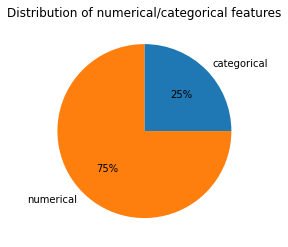

In [226]:
plt.title('Distribution of numerical/categorical features')
plt.pie([len(categorical), len(numerical)], labels=['categorical', 'numerical'], autopct='%.0f%%')
plt.show()

In [227]:
print(f'Our current dataset would have {round(len(numerical) / (len(numerical) + len(categorical)), 2) * 100}% numerical feature')

Our current dataset would have 75.0% numerical feature


### 5.3 Distribution of numerical columns <a id="5.3"></a>

#### Label
- About 23% of our dataset churn, which is a pretty significant amount

0    173
1     52
Name: churn, dtype: int64


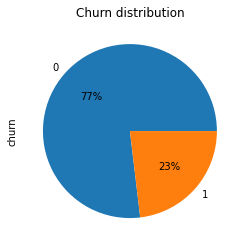

In [228]:
predictor = pd_melt['churn'].value_counts()

print(predictor)

plt.title('Churn distribution')
predictor.plot.pie(autopct='%.0f%%')
plt.show()

#### Features
- Almost all of our datasets below show similar right skewed distributions for churned and non-churned customers
- `dayOfServiceLen` which represents user's length of service shows the highest distinguishment when comparing churn and non-churn customers

In [229]:
def plot_distribution(df, hue, filter_col=None, bins='auto'):
    '''
    Plots distribution of numerical columns
    By default, exclude object, datetime, timedelta and bool types and only consider numerical columns
    @param df (DataFrame) - dataset
    @param hue (str) - column of dataset to apply hue (useful for classification)
    @param filter_col (array) - optional argument, features to be included in plot
    @param bins (int) - defaults to auto for seaborn, sets number of bins of histograms
    '''
    if filter_col == None:
        filter_col = df.select_dtypes(exclude=['object', 'datetime', 'timedelta', 'bool']).columns
    num_cols = len(list(filter_col))
    width = 3
    height = num_cols // width if num_cols % width == 0 else num_cols // width + 1
    plt.figure(figsize=(18, height * 3))
    for i, col in zip(range(num_cols), filter_col):
        plt.subplot(height, width, i + 1)
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.title(f'Distribution of {col}')
        sns.histplot(df, x=col, hue=hue, element="step", stat="count", common_norm=False, bins=bins)
    plt.tight_layout()
    plt.show()

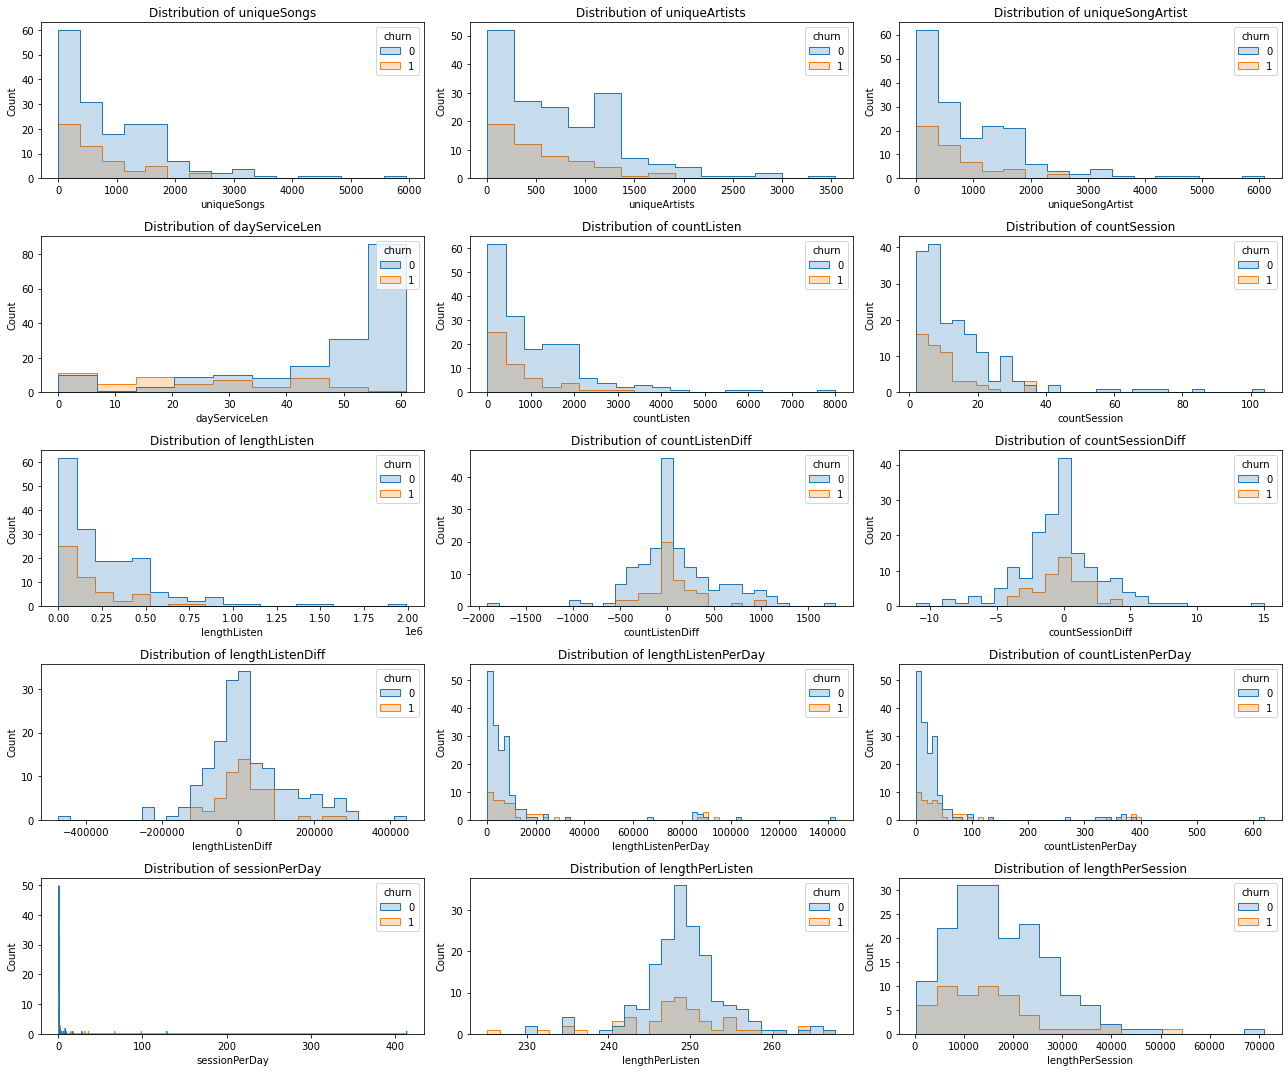

In [230]:
plot_distribution(pd_melt, 'churn', filter_col=numerical)

In [231]:
def log_transform(df, skewed_cols):
    '''
    Applies log transform to dataset columns
    @param - df (DataFrame) - dataset
    @param - skewed_cols (array) - columns to apply log transform
    returns - updated dataset
    '''
    features_log_transformed = df.copy()
    # The logarithm of 0 is undefined, so we must translate the values by a small amount above 0 to apply the the logarithm successfully.
    features_log_transformed[skewed_cols] = features_log_transformed[skewed_cols].apply(lambda x: np.log(x + 1))
    return features_log_transformed

Let's attempt log transforming our data to observe whether it makes a huge difference in our distributions
- Overall, log transforming our data greatly normalized our distributions
- Despite that, churn and non-churn customers still seem to share similar distributions

/opt/conda/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


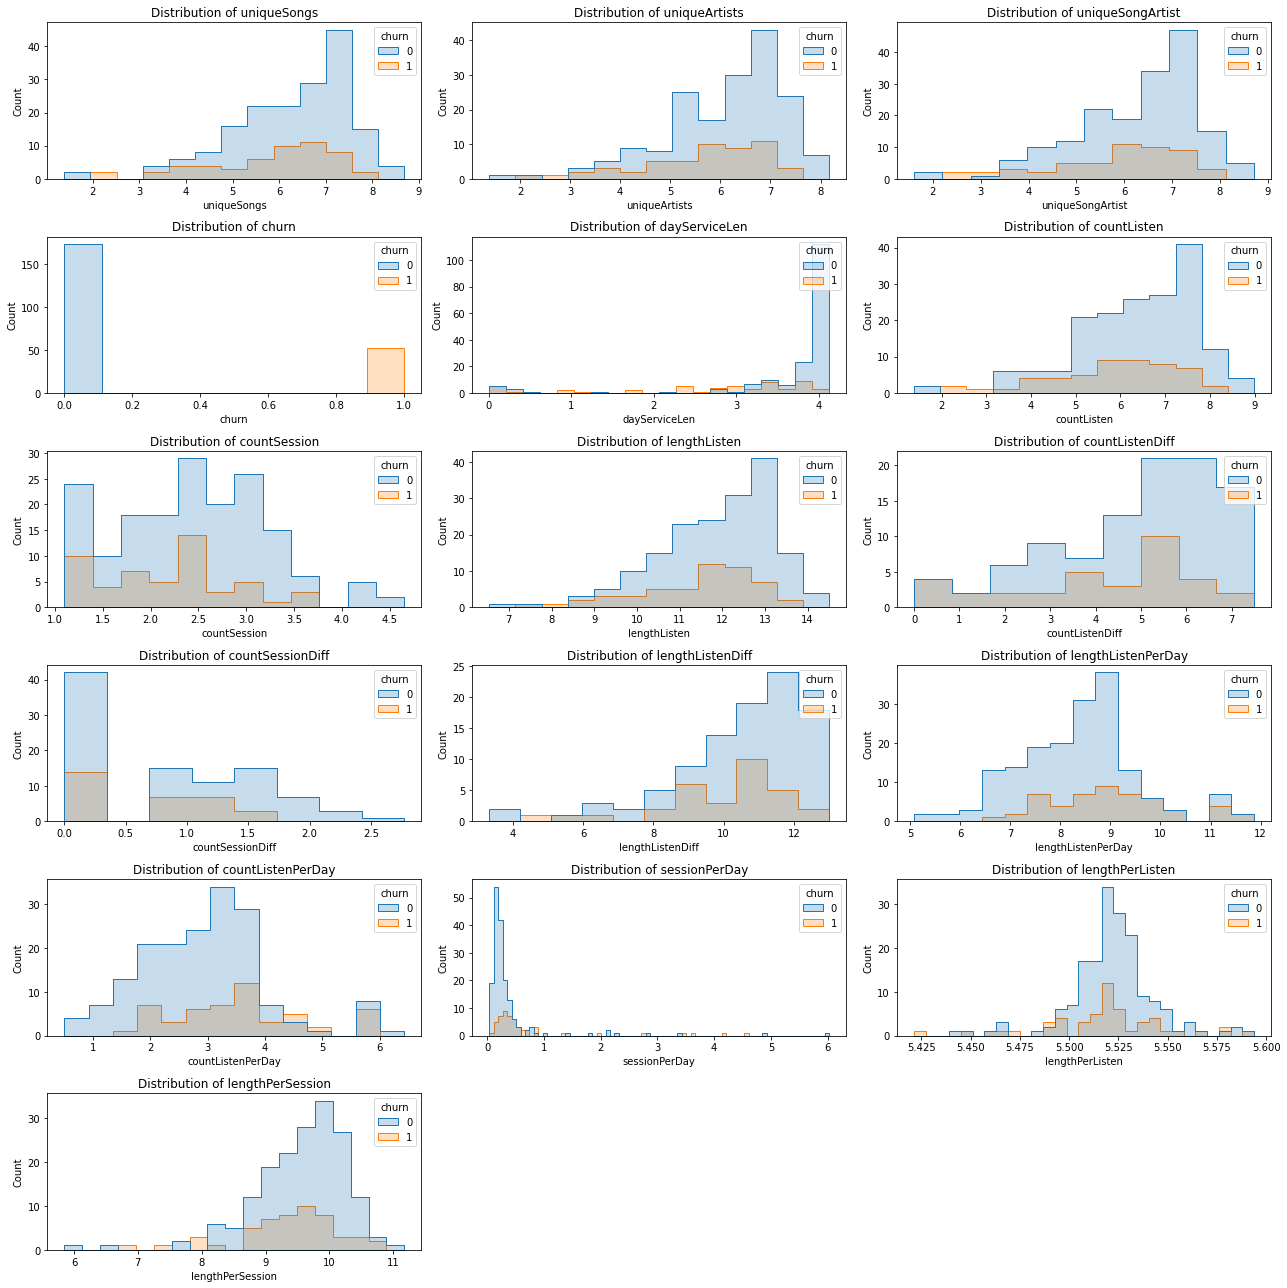

In [232]:
plot_distribution(log_transform(pd_melt, numerical), 'churn')

#### Categorical data distribution

In [252]:
def plot_cat_distribution(data, colname):
    '''
    Plots barplot for categorical columns and piechart showing proportions of churned vs non-churned customers
    @param - data (panas dataframe)
    @param - colname (str) - column of dataframe referenced
    '''
    # https://www.statology.org/seaborn-stacked-bar-plot/
    plt.figure(figsize=(15,5))
    ax1 = plt.subplot(1, 3, 1)
    tmp = data.copy()
    tmp['count'] = 1
    x = tmp.groupby([colname, 'churn']).count().reset_index()[[colname, 'churn','count']]
    # churn index 0, 1 doesn't relate to No, Yes, relates to pivoted index only
    x = x.pivot(index='churn', columns=colname).transpose().reset_index().drop('level_0', axis=1)
    x = x.fillna(0)

    plt.title(f'Distribution of {colname}')
    plt.ylabel('Count')
    x.plot.bar(x=colname, stacked=True, ax=ax1, color=['green', 'lightgreen'])

    ax2 = plt.subplot(1, 3, 2)
    plt.title(f'Proportion of {colname} for churned customers')
    plt.pie(x['Yes'], labels=x[colname], autopct='%.0f%%')

    plt.subplot(1, 3, 3)
    plt.title(f'Proportion of {colname} for non-churned customers')
    plt.pie(x['No'], labels=x[colname], autopct='%.0f%%')

    plt.tight_layout()
    plt.show()

    x.index.rename('index', inplace=True)
    print(x)
    tmp_sum = x[['No','Yes']].sum(axis=1)
    x['No'] = x['No'] / tmp_sum
    x['Yes'] = x['Yes'] / tmp_sum
    print(x)
    print(tmp_sum / tmp_sum.sum())

In [253]:
tmp_pd_melt = pd_melt.copy()
tmp_pd_melt['churn'] = tmp_pd_melt['churn'].apply(lambda x: 'Yes' if x == 1 else 'No')

#### Gender
Females seem to churn more than males

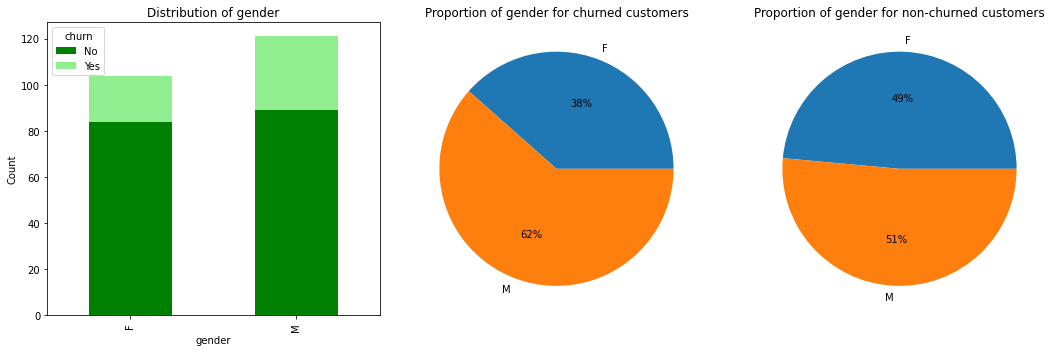

churn gender  No  Yes
index                
0          F  84   20
1          M  89   32
churn gender        No       Yes
index                           
0          F  0.807692  0.192308
1          M  0.735537  0.264463
index
0    0.462222
1    0.537778
dtype: float64


In [254]:
plot_cat_distribution(tmp_pd_melt, 'gender')

#### Level
- I would expect paid customers to churn less
- However surprisingly, the proportion of churn/non-churn seems to be pretty consistent within free and paid

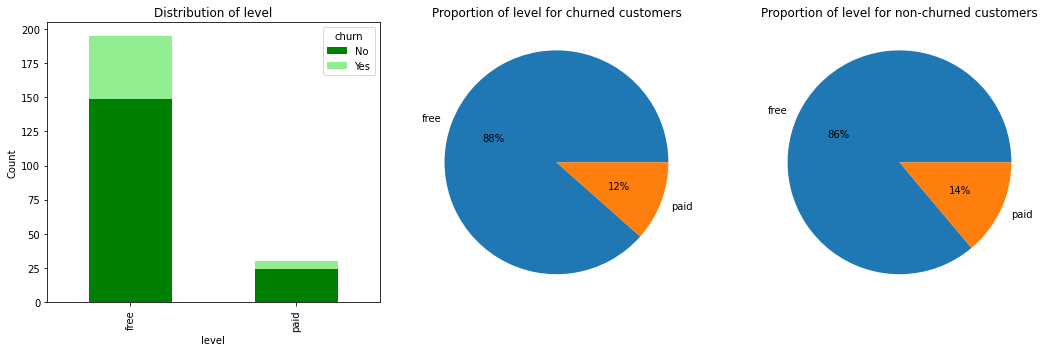

churn level   No  Yes
index                
0      free  149   46
1      paid   24    6
churn level        No       Yes
index                          
0      free  0.764103  0.235897
1      paid  0.800000  0.200000
index
0    0.866667
1    0.133333
dtype: float64


In [255]:
plot_cat_distribution(tmp_pd_melt, 'level')

#### Region
- Higher proportion of churn for customers in the `South` compared to non-churned
- Lower proportion of churn for customers in `Northest`compared to non-churned

churn     region  No  Yes
0        Midwest  28   10
1      Northeast  36    6
2          South  63   22
3           West  46   14


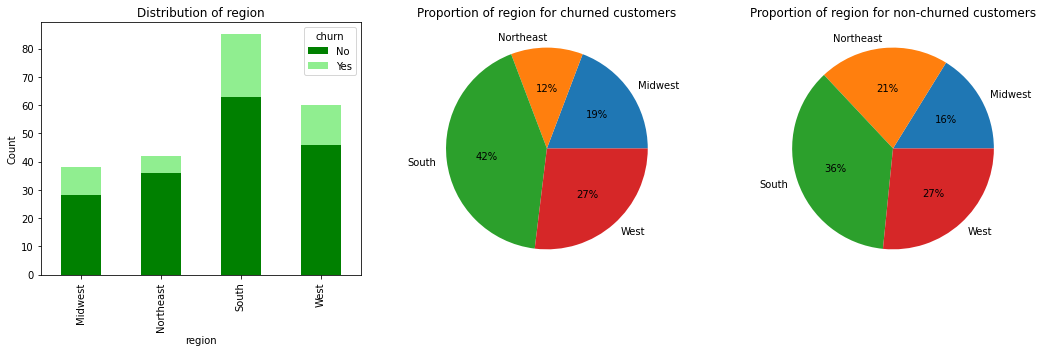

churn     region  No  Yes
index                    
0        Midwest  28   10
1      Northeast  36    6
2          South  63   22
3           West  46   14
churn     region        No       Yes
index                               
0        Midwest  0.736842  0.263158
1      Northeast  0.857143  0.142857
2          South  0.741176  0.258824
3           West  0.766667  0.233333
index
0    0.168889
1    0.186667
2    0.377778
3    0.266667
dtype: float64


In [245]:
# ['gender', 'level' , 'location', 'region', 'division']
plot_cat_distribution(tmp_pd_melt, 'region')

#### Division
- Higher proportion of churn for customers in the `East South Central` division compared to non-churn
- Slightly less `churn` customers in South Atlantic, and **0** churn in `New England`

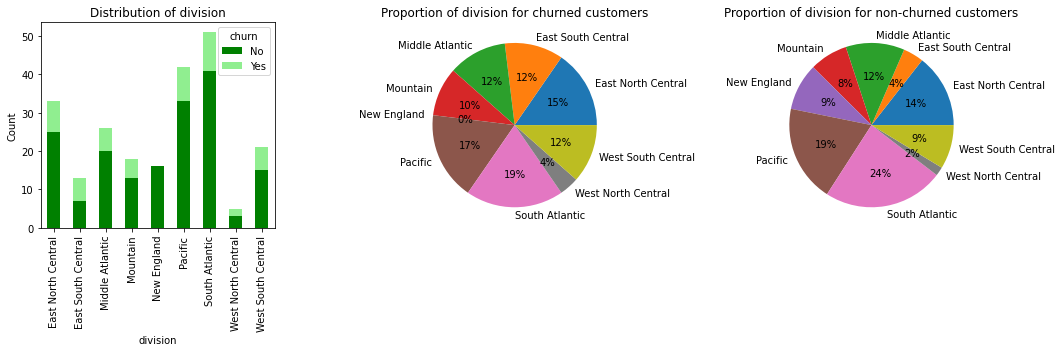

churn            division    No   Yes
index                                
0      East North Central  25.0   8.0
1      East South Central   7.0   6.0
2         Middle Atlantic  20.0   6.0
3                Mountain  13.0   5.0
4             New England  16.0   0.0
5                 Pacific  33.0   9.0
6          South Atlantic  41.0  10.0
7      West North Central   3.0   2.0
8      West South Central  15.0   6.0
churn            division        No       Yes
index                                        
0      East North Central  0.757576  0.242424
1      East South Central  0.538462  0.461538
2         Middle Atlantic  0.769231  0.230769
3                Mountain  0.722222  0.277778
4             New England  1.000000  0.000000
5                 Pacific  0.785714  0.214286
6          South Atlantic  0.803922  0.196078
7      West North Central  0.600000  0.400000
8      West South Central  0.714286  0.285714
index
0    0.146667
1    0.057778
2    0.115556
3    0.080000
4    0.071111


In [257]:
plot_cat_distribution(tmp_pd_melt, 'division')

### 5.4 Correlation of numerical data <a id="4.4"></a>
- It's important to understand correlations among features, especially dealing with datasets with large amount of features
    - We may avoid using **two different features** which have very high correlation as they may suggest same amount of information, hence duplication of information.
    - We may not use features with very limited correlation **with target values** as they may not have effect over predictions, but instead increase the complexity of our model

In [274]:
numerical_churn = numerical + ['churn']
numerical_churn

['uniqueSongs',
 'uniqueArtists',
 'uniqueSongArtist',
 'dayServiceLen',
 'countListen',
 'countSession',
 'lengthListen',
 'countListenDiff',
 'countSessionDiff',
 'lengthListenDiff',
 'lengthListenPerDay',
 'countListenPerDay',
 'sessionPerDay',
 'lengthPerListen',
 'lengthPerSession',
 'churn']

In [280]:
corr_data = pd_melt[numerical_churn].corr()

There doesn't seem to be numerical features which have significantly high correlation with our `churn` predictor column, which is good

However, there are clumps of features, i.e. `uniqueArtists`, `uniqueSongArtist`, `countListen`, `countSession` and `lengthListen` which have very high correlation between them. It may make sense to remove these features since they would throw our model off. But, since modern implementations of models would already incorporate regularization for linear models (e.g. Logistic Regression), and ensemble methods are not affected by multicolinearity, I will remain these highly correlated features for the purpose of this project.

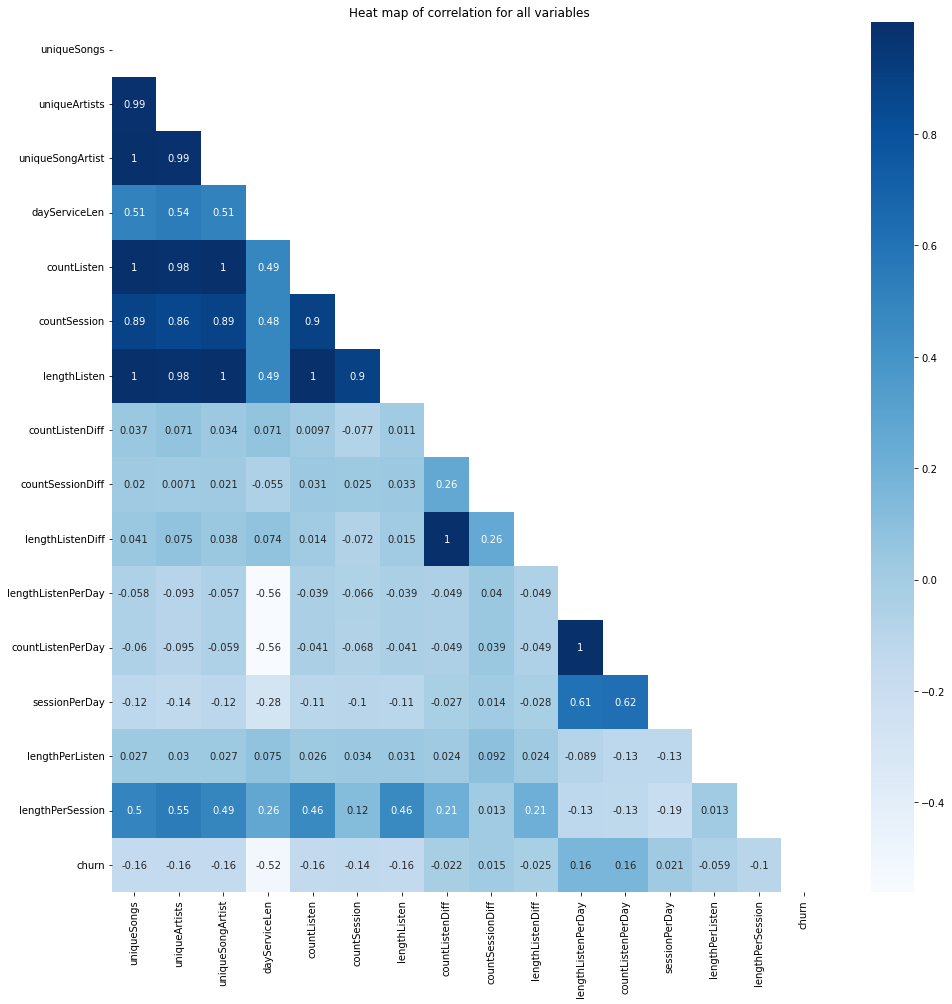

In [282]:
plt.figure(figsize=(16,16))
plt.title('Heat map of correlation for all variables')

matrix = np.triu(corr_data)

# applied drop_first = True here
sns.heatmap(corr_data, cmap='Blues', annot=True, mask=matrix)
plt.show()

### 5.5 Cardinality of Categorical variables <a id="4.5"></a>
- Cardinality measures the magnitude of unique labels in our categorical features, so performing OneHot encoding with `pd.get_dummies` or OneHotEncoder may not pose any issues for model performance

In [283]:
def cardinality_plot(df, filter_col=None):
    '''
    Input list of categorical variables to filter
    Default is None where it would only consider columns which have type 'Object'
    @param df (DataFrame) - dataset
    @param filter_col (array) - optional argument to specify columns we want to filter
    '''
    if filter_col == None:
        filter_col = df.select_dtypes(include='object').columns
    num_unique = []
    for col in filter_col:
        num_unique.append(len(df[col].unique()))
    plt.bar(list(filter_col), num_unique)
    plt.title('Number of unique categorical variables')
    plt.xlabel('Column name')
    plt.ylabel('Num unique')
    plt.xticks(rotation=90)
    plt.yticks([0, 1, 2, 3, 4])
    plt.show()
    return pd.Series(num_unique, index=filter_col).sort_values(ascending=False)

Except for `location`, the other numerical columns have relatively low or low-mid cardinality.
I will remove `location` from our modelling but remain the rest of our categorical features.

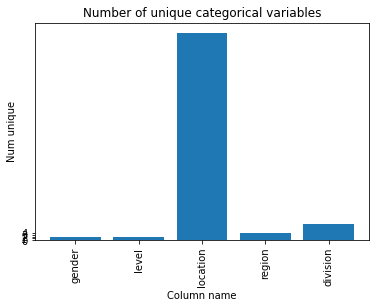

location    114
division      9
region        4
gender        2
level         2
dtype: int64

In [284]:
cardinality_plot(pd_melt, categorical)

In [314]:
def log_transform(df, columns):
    '''
    Log trasform columns in dataframe
    @df - spark dataframe
    @columns - array of string of column names to be log transformed
    returns updated spark dataframe
    '''
    log_transform_func = F.udf(lambda x: np.log10(x + 1), FloatType())
    for col in columns:
        df = df.withColumn(col, log_transform_func(df[col]))
    return df

In [293]:
# log transform dataset
# df_melt = log_transform(df_melt, numerical)

## 6. Modelling <a id="6.0"></a>
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### 6.1 Packages <a id="6.1"></a>

In [427]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler, OneHotEncoder, StringIndexer 
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

import re

### 6.2 Splitting data <a id="6.2"></a>

In [380]:
df_melt_copy = df_melt.withColumn("label", df_melt.churn)
df_melt_copy

DataFrame[userId: string, gender: string, level: string, location: string, uniqueSongs: bigint, uniqueArtists: bigint, uniqueSongArtist: bigint, churn: int, dayServiceLen: float, countListen: bigint, countSession: bigint, lengthListen: double, countListenDiff: bigint, countSessionDiff: bigint, lengthListenDiff: double, lengthListenPerDay: double, countListenPerDay: double, sessionPerDay: double, lengthPerListen: double, lengthPerSession: double, region: string, division: string, label: int]

In [300]:
0.2/0.8

0.25

In [381]:
'''
Splitting data to train:val:test of 60:20:20
'''
# rest will be used to train on entire population
rest, test = df_melt_copy.randomSplit([0.8, 0.2], seed=42)
train, val = rest.randomSplit([0.75, 0.25], seed=42)

### 6.3 Defining Pipelines <a id="6.3"></a>

In [326]:
numerical_assembler = VectorAssembler(inputCols=numerical, outputCol="numericalFeatures")
standardise = StandardScaler(inputCol="numericalFeatures", outputCol="standardNumFeatures", withStd=True, withMean=True)
minmax = MinMaxScaler(inputCol="standardNumFeatures", outputCol="minmaxNumFeatures")

In [340]:
# converting categorical to numerical
# https://datascience.stackexchange.com/questions/6268/how-to-convert-categorical-data-to-numerical-data-in-pyspark

# transforming categoricals to numerical and then one hot encoding it
# https://stackoverflow.com/questions/34907117/how-to-pass-categorical-features-to-linear-regression-modeling-in-pyspark-mllib

# exclude 'location' feature
inputCols = ['gender', 'level', 'region', 'division']
outputColsIndexer = [x + 'SI' for x in inputCols]

indexer = StringIndexer(inputCols = inputCols, outputCols=outputColsIndexer)

outputColsOH = [x + 'OH' for x in inputCols]
onehot = OneHotEncoder(inputCols=outputColsIndexer, outputCols=outputColsOH)
categorical_assembler = VectorAssembler(inputCols=outputColsOH, outputCol="categoricalFeatures")

In [366]:
# Combining sparse and dense vector
# https://stackoverflow.com/questions/33273712/how-to-merge-multiple-feature-vectors-in-dataframe

total_assembler = VectorAssembler(inputCols=['minmaxNumFeatures', 'categoricalFeatures'], outputCol='features')

In [367]:
pipeline = Pipeline(stages=[numerical_assembler, standardise, minmax, indexer, onehot, categorical_assembler, total_assembler])

In [384]:
pipeline.fit(train).transform(train).head()

Row(userId='10', gender='M', level='paid', location='Laurel, MS', uniqueSongs=629, uniqueArtists=565, uniqueSongArtist=633, churn=0, dayServiceLen=42.43672561645508, countListen=673, countSession=6, lengthListen=166866.37250999993, countListenDiff=-203, countSessionDiff=2, lengthListenDiff=-48180.54478999992, lengthListenPerDay=3932.121766842835, countListenPerDay=15.858904998528928, sessionPerDay=0.14138696878331883, lengthPerListen=247.94408991084686, lengthPerSession=27811.062084999987, region='South', division='East South Central', label=0, numericalFeatures=DenseVector([629.0, 565.0, 633.0, 42.4367, 673.0, 6.0, 166866.3725, -203.0, 2.0, -48180.5448, 3932.1218, 15.8589, 0.1414, 247.9441, 27811.0621]), standardNumFeatures=DenseVector([-0.3973, -0.331, -0.3968, -0.016, -0.3968, -0.6026, -0.3993, -0.6779, 0.6836, -0.6549, -0.3678, -0.3625, -0.1256, -0.1374, 1.1354]), minmaxNumFeatures=DenseVector([0.1053, 0.1587, 0.1034, 0.6957, 0.0838, 0.0392, 0.0835, 0.5701, 0.5, 0.5692, 0.0264, 0.0

### 6.4 Perform Cross validation <a id="6.4"></a>

In [ ]:
def evaluate_model(y_trueTrain, y_predTrain, y_trueTest, y_predTest, y_testProba):
    '''
    Wrapper function for evaluating classification results
    '''
    train_acc = accuracy_score(y_trueTrain, y_predTrain)
    test_acc = accuracy_score(y_trueTest, y_predTest)
    fscore = f1_score(y_trueTest, y_predTest, zero_division=0)
    precision = precision_score(y_trueTest, y_predTest, zero_division=0)
    recall = recall_score(y_trueTest, y_predTest, zero_division=0)
    # linear models would not have .predict_proba method so, if fails, append 0 to roc_auc
    try:
        roc_auc = roc_auc_score(y_trueTest, y_testProba)
    except:
        roc_auc = 0
    return {
        'train_acc': train_acc, 
        'test_acc' : test_acc, 
        'fscore': fscore, 
        'precision': precision, 
        'recall': recall, 
        'roc_auc': roc_auc
    }

#### Logistic Regression

In [412]:
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
pipeline_lr = Pipeline(stages=[numerical_assembler, standardise, minmax, indexer,\
                                onehot, categorical_assembler, total_assembler, lr])
lrModel = pipeline_lr.fit(train)
lr_res_test = lrModel.transform(val).select('label', 'prediction', 'probability').toPandas()
lr_res_train = lrModel.transform(train).select('label', 'prediction', 'probability').toPandas()

In [480]:
lr_results = evaluate_model(lr_res_train['label'],lr_res_train['prediction'],lr_res_test['label'],lr_res_test['prediction'],\
               lr_res_test['probability'].apply(lambda x: x[1]))
lr_results

{'train_acc': 0.8456375838926175,
 'test_acc': 0.8780487804878049,
 'fscore': 0.7368421052631579,
 'precision': 0.5833333333333334,
 'recall': 1.0,
 'roc_auc': 0.9579831932773109}

#### GradientBoostingTree
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.GBTClassifier.html

In [408]:
gbt = GBTClassifier()
pipeline_gbt = Pipeline(stages=[numerical_assembler, standardise, minmax, indexer,\
                                onehot, categorical_assembler, total_assembler, gbt])
gbtModel = pipeline_gbt.fit(train)
gbt_res_test = gbtModel.transform(val).select('label', 'prediction', 'probability').toPandas()
gbt_res_train = gbtModel.transform(train).select('label', 'prediction', 'probability').toPandas()

In [481]:
gbt_results = evaluate_model(gbt_res_train['label'],gbt_res_train['prediction'],gbt_res_test['label'],gbt_res_test['prediction'],\
               gbt_res_test['probability'].apply(lambda x: x[1]))
gbt_results

{'train_acc': 1.0,
 'test_acc': 0.8048780487804879,
 'fscore': 0.6,
 'precision': 0.46153846153846156,
 'recall': 0.8571428571428571,
 'roc_auc': 0.8193277310924371}

#### RandomForest

In [410]:
rf = RandomForestClassifier()
pipeline_rf = Pipeline(stages=[numerical_assembler, standardise, minmax, indexer,\
                                onehot, categorical_assembler, total_assembler, rf])
rfModel = pipeline_rf.fit(train)
rf_res_test = rfModel.transform(val).select('label', 'prediction', 'probability').toPandas()
rf_res_train = rfModel.transform(train).select('label', 'prediction', 'probability').toPandas()

In [482]:
rf_results = evaluate_model(rf_res_train['label'],rf_res_train['prediction'],rf_res_test['label'],rf_res_test['prediction'],\
               rf_res_test['probability'].apply(lambda x: x[1]))
rf_results

{'train_acc': 0.959731543624161,
 'test_acc': 0.8780487804878049,
 'fscore': 0.6666666666666666,
 'precision': 0.625,
 'recall': 0.7142857142857143,
 'roc_auc': 0.9243697478991597}

In [495]:
cv_results = pd.DataFrame(columns=['accuracy_train','accuracy_cv','fscore_cv','precision_cv','recall_cv', 'roc_auc_cv'])
cv_results.loc['LogisticRegression'] = lr_results.values()
cv_results.loc['GradientBoostingTree'] = gbt_results.values()
cv_results.loc['RandomForest'] = rf_results.values()

In [496]:
cv_results.style.apply(lambda x: ["background: lightgreen" if abs(v) == max(x) else "" for v in x], axis = 0)

,accuracy_train,accuracy_cv,fscore_cv,precision_cv,recall_cv,roc_auc_cv
LogisticRegression,0.845638,0.878049,0.736842,0.583333,1.000000,0.957983
GradientBoostingTree,1.000000,0.804878,0.600000,0.461538,0.857143,0.819328
RandomForest,0.959732,0.878049,0.666667,0.625000,0.714286,0.924370


### 6.5 Choosing models <a id="6.5"></a>

#### Metrics
1. Accuracy is usually not a good metric to measure classifications
    - E.g. merely predicting all our customers to 'not-churn' would already provide an accuracy of 77%.
2. Recall and precision, fscore
    - Recall measures how much of our positive labels are labelled as positive - TP / (TP + FN). In our case, our `LogisticRegression` correctly identifies all customers who will churn.
    - Recall cannot be considered in isolation, and need to be considered with precision since they are trade-offs. For our `LogisticRegression`, out of all customers **labelled** to be churned, only 58% will actually churn. If we were to have a marketing campaign to address churn, 42% (1 - 0.58) of our cost will be wasted towards non-churned customers.
    - We can use the **fscore** metric to consider both recall and precision as well
3. ROC_AUC
    - ROC_AUC measures our true positive against false positive rate 
    - The higher our AUC, the better the performance of the model at distinguishing between the positive and negative classes.

#### Considerations
It's not easy to determine how much recall or precision to allow for our model. This usually requires additional discussion with the marketing team or management.

The good thing about our Classifiers used is that they provide us with probabilities in their classifications. This allows us to determine our threshold in interpreting the classification (rather than simply using 50% as the probability cut-off).

A higher ROC_AUC would suggest that our model would give us more leeway and balance in adjusting our probability thresholds, and subsequently more options to choose from with regards to recall-precision.

In summary, I will prioritise ROC_AUC first, and Fscore second, as metrics for this case study.

Sorting our models by `roc_auc`, and then `fscore` shows that `LogisticRegression` is performing best.

We will now perform hyperparameter tuning for LogisticRegression

### 6.6 Hyperparameter tuning <a id="6.6"></a>

In [417]:
'''
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html#pyspark.ml.classification.LogisticRegression.setParams

setParams(*, featuresCol='features', labelCol='label', predictionCol='prediction', maxIter=100, 
    regParam=0.0, elasticNetParam=0.0, tol=1e-06, fitIntercept=True, threshold=0.5, thresholds=None, 
    probabilityCol='probability', rawPredictionCol='rawPrediction', standardization=True, weightCol=None, 
    aggregationDepth=2, family='auto', lowerBoundsOnCoefficients=None, upperBoundsOnCoefficients=None, 
    lowerBoundsOnIntercepts=None, upperBoundsOnIntercepts=None, maxBlockSizeInMB=0.0)
'''
''

''

In [419]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .addGrid(lr.maxIter,[50, 100]) \
    .build()

crossval = CrossValidator(estimator=pipeline_lr,
                         estimatorParamMaps=paramGrid,
                         evaluator=MulticlassClassificationEvaluator(),
                         numFolds=3)

In [ ]:
# train on rest (i.e. 80% of dataset) instead of train
cvModel = crossval.fit(rest)
cvModel.avgMetrics

22/05/16 16:36:13 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.
22/05/16 16:36:13 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


[0.8011084544393228,
 0.8222872837788751,
 0.7284659848286738,
 0.7284659848286738]

In [435]:
cv_res_test = cvModel.transform(test).select('label', 'prediction', 'probability').toPandas()
# again, rest is 80% of our data, use this to train since we already validated our models above
cv_res_train = cvModel.transform(rest).select('label', 'prediction', 'probability').toPandas()

In [436]:
cv_metrics = evaluate_model(cv_res_train['label'],cv_res_train['prediction'],cv_res_test['label'],cv_res_test['prediction'],\
               cv_res_test['probability'].apply(lambda x: x[1]))
cv_metrics

{'train_acc': 0.8894736842105263,
 'test_acc': 0.8571428571428571,
 'fscore': 0.7368421052631577,
 'precision': 0.7,
 'recall': 0.7777777777777778,
 'roc_auc': 0.858974358974359}

#### Best params

In [464]:
# https://stackoverflow.com/questions/52498970/how-to-get-the-best-hyperparameter-value-after-crossvalidation-in-pyspark
cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)]

{Param(parent='LogisticRegression_e765de70ec6a', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
 Param(parent='LogisticRegression_e765de70ec6a', name='maxIter', doc='max number of iterations (>= 0).'): 100}

In [498]:
cv_res_test.shape

(35, 3)

### Reference
- [High ROC but low F1](https://www.quora.com/What-does-it-mean-to-have-high-AUC-but-low-F1-score)

### 6.7 Analysis of Results

In [433]:
def plot_confusion_matrix(y_true, y_pred, title):
    '''
    Plots confusion matrix
    @param y_true - array of actual labels
    @param y_pred - array of predictions
    @title title - string of title
    '''
    conf_matrix = confusion_matrix(y_true, y_pred)
    matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Churn", "Churn"])
    matrix_display.plot(cmap='Greens')
    # adding title - https://github.com/scikit-learn/scikit-learn/discussions/20690
    matrix_display.ax_.set_title(title)
    plt.grid(False)
    plt.show()

    # Calculating recall (sensitivity), precision and specificity
    tn = conf_matrix[0][0]
    tp = conf_matrix[1][1]
    fn = conf_matrix[1][0]
    fp = conf_matrix[0][1]
    print(f'True Positive Rate/Recall/Sensitivity: {round(tp/(tp+fn), 6)}')
    # basically inverse of TPR
    print(f'False Positive Rate/(1 - Specificity): {round(fp/(tn+fp), 6)}')
    print(f'Precision                            : {round(tp/(tp+fp), 6)}')

Looking at our confusion matrix below, the default threshold of 50% is able to correctly predict 77.78% of churn customers `(7/(7+2))`, this also comes with a decent precision at 70% `(7/(7+3))`

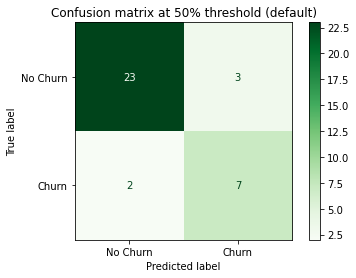

True Positive Rate/Recall/Sensitivity: 0.777778
False Positive Rate/(1 - Specificity): 0.115385
Precision                            : 0.7


In [434]:
plot_confusion_matrix(cv_res_test['label'], cv_res_test['prediction'], "Confusion matrix at 50% threshold (default)")

Our ROC AUC curve below clearly shows the trade off between recall (true positive rate) and False positive rate. It (roc_auc - 0.859) is well above the minimum (denoted by orange) of 0.5

Trade off discussions with management need to be had on whether to prioritise maximising true positive churn identification or to prioritise reducing false positives

In [423]:
test_proba = cv_res_test['probability'].apply(lambda x: x[1])

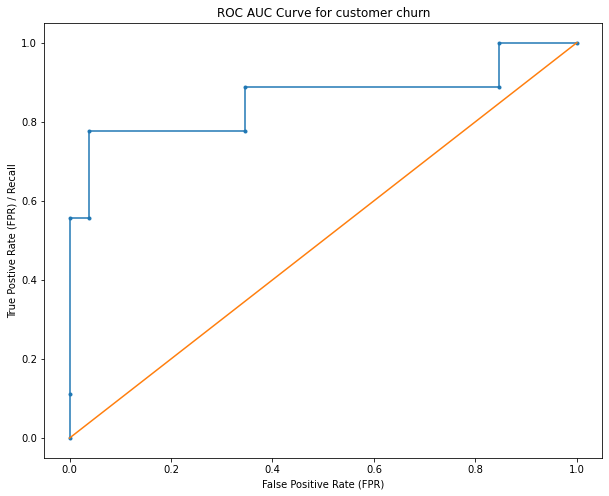

In [428]:
# fpr = false positive rate, tpr = true positive rate
fpr, tpr, _ = roc_curve(cv_res_test['label'], test_proba)

plt.figure(figsize=(10,8))
plt.title('ROC AUC Curve for customer churn')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Postive Rate (FPR) / Recall')
plt.plot(fpr, tpr, marker='.', label='LR')
plt.plot([0, 1], [0, 1])
plt.show()

The intersection in our Recall/Precision graph below represents the recall-precision in our tuned LogisticRegression model. The default 50% decision threshold derives this recall-precision trade off of 77.8%/70%. 

By tweaking our decision threshold, we can customise our preferred recall/precision rates

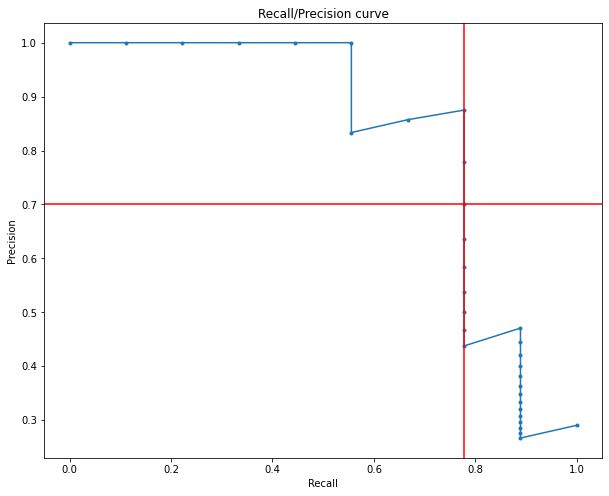

In [437]:
lr_precision, lr_recall, _ = precision_recall_curve(cv_res_test['label'], test_proba)

plt.figure(figsize=(10,8))
plt.title('Recall/Precision curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(lr_recall, lr_precision, marker='.', label='LR')
plt.axhline(y=cv_metrics['precision'], color='r')
plt.axvline(x=cv_metrics['recall'], color='r')
plt.show()

In [438]:
def classify_custom_threshold(y_true, y_pred_proba, threshold=0.5):
    '''
    Identifies custom threshold and plots confusion matrix
    @y_true - array of actual labels
    @y_pred_proba - array of probabilities of predictions
    @threshold - decision threshold which is defaulted to 50%
    '''
    y_pred = y_pred_proba >= threshold
    plot_confusion_matrix(y_true, y_pred, f'Confusion matrix at {round(threshold * 100, 1)}% decision threshold')

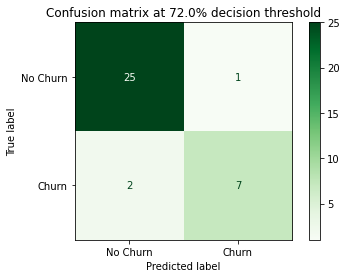

True Positive Rate/Recall/Sensitivity: 0.777778
False Positive Rate/(1 - Specificity): 0.038462
Precision                            : 0.875


In [442]:
classify_custom_threshold(cv_res_test['label'], test_proba, 0.72)

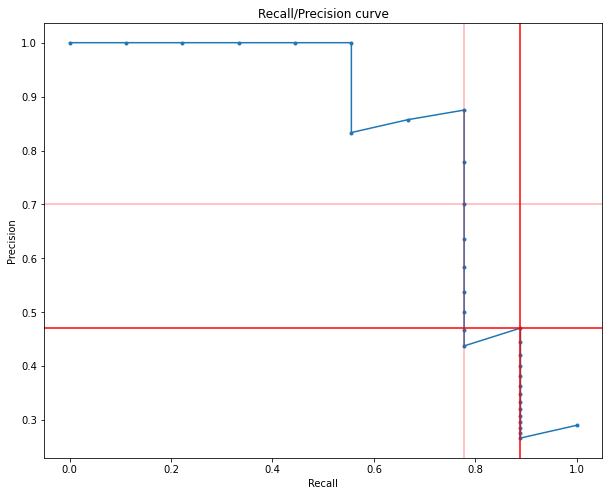

In [509]:
lr_precision, lr_recall, _ = precision_recall_curve(cv_res_test['label'], test_proba)

plt.figure(figsize=(10,8))
plt.title('Recall/Precision curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(lr_recall, lr_precision, marker='.', label='LR')
plt.axhline(y=cv_metrics['precision'], color='r', alpha=0.3)
plt.axvline(x=cv_metrics['recall'], color='r', alpha=0.3)
plt.axhline(y=0.470588, color='r')
plt.axvline(x=0.888889, color='r')
plt.show()

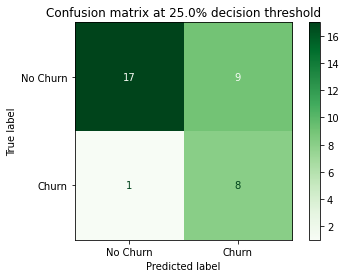

True Positive Rate/Recall/Sensitivity: 0.888889
False Positive Rate/(1 - Specificity): 0.346154
Precision                            : 0.470588


In [449]:
classify_custom_threshold(cv_res_test['label'], test_proba, 0.25)

## Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.